# Fun with Variational Autoencoders

This is a starter kernel to use **Labelled Faces in the Wild (LFW) Dataset** in order to maintain knowledge about main Autoencoder principles. PyTorch will be used for modelling.


## Fork it and give it an upvote.




![architecture](https://miro.medium.com/max/3636/1*LSYNW5m3TN7xRX61BZhoZA.png)

Useful links:


* [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Conditional VAE (Russian)](https://habr.com/ru/post/331664/)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
* [Introducing Variational Autoencoders (in Prose and Code)](https://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html)
* [How Autoencoders work - Understanding the math and implementation (Notebook)](https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases)
* [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)



## A bit of theory

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

source: https://blog.keras.io/building-autoencoders-in-keras.html


In [1]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import requests
import zipfile
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


## Load datasets

In [2]:
datasets_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/autoencoder/variational-autoencoder-and-faces-generation/lfw-deepfunneled.zip"
attributes_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/autoencoder/variational-autoencoder-and-faces-generation/lfw_attributes.txt"

notebook_path = os.getcwd()

tmp_folder_path = os.path.join(notebook_path, "tmp")

if not os.path.exists(tmp_folder_path):
    os.makedirs(tmp_folder_path)

tmp_zip_path = os.path.join(tmp_folder_path,"zip-store")

if not os.path.exists(tmp_zip_path):
    os.makedirs(tmp_zip_path)
    
datasets_response = requests.get(datasets_url)
attributes_response = requests.get(attributes_url)

datasets_name = os.path.basename(datasets_url)
attributes_name = os.path.basename(attributes_url)

datasets_save_path = os.path.join(tmp_zip_path, datasets_name)
attributes_save_path = os.path.join(tmp_folder_path, attributes_name)

with open(datasets_save_path, "wb") as file:
    file.write(datasets_response.content)

with open(attributes_save_path, "wb") as file:
    file.write(attributes_response.content)

In [3]:
zip_file_path = f"./tmp/zip-store/{datasets_name}"
extract_path = "./tmp/"

zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()

In [4]:
DATASET_PATH ="./tmp/lfw-deepfunneled/"
ATTRIBUTES_PATH = "./tmp/lfw_attributes.txt"

## Explore the data

Image data is collected from DATASET_PATH and a dataset is created in which the person information for each image is extracted and used for subsequent data analysis or processing. Finally, the filter() function is used to limit the size of the dataset by retaining only information about people who appear less than 25 times.

In [5]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)

dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

person                                               path
0              Ian_Knop  ./tmp/lfw-deepfunneled/Ian_Knop/Ian_Knop_0001.jpg
1          Dan_LaCoutre  ./tmp/lfw-deepfunneled/Dan_LaCoutre/Dan_LaCout...
2          Barry_Hinson  ./tmp/lfw-deepfunneled/Barry_Hinson/Barry_Hins...
3        Corey_Maggette  ./tmp/lfw-deepfunneled/Corey_Maggette/Corey_Ma...
4           Guy_Ritchie  ./tmp/lfw-deepfunneled/Guy_Ritchie/Guy_Ritchie...
5           Guy_Ritchie  ./tmp/lfw-deepfunneled/Guy_Ritchie/Guy_Ritchie...
6  Pierre_Van_Hooijdonk  ./tmp/lfw-deepfunneled/Pierre_Van_Hooijdonk/Pi...
7         Mickey_Loomis  ./tmp/lfw-deepfunneled/Mickey_Loomis/Mickey_Lo...
8         Dennis_Archer  ./tmp/lfw-deepfunneled/Dennis_Archer/Dennis_Ar...
9          Ronde_Barber  ./tmp/lfw-deepfunneled/Ronde_Barber/Ronde_Barb...

Let's group the dataset and look at the amount of photo data for the first 200 people.

<Axes: xlabel='person'>

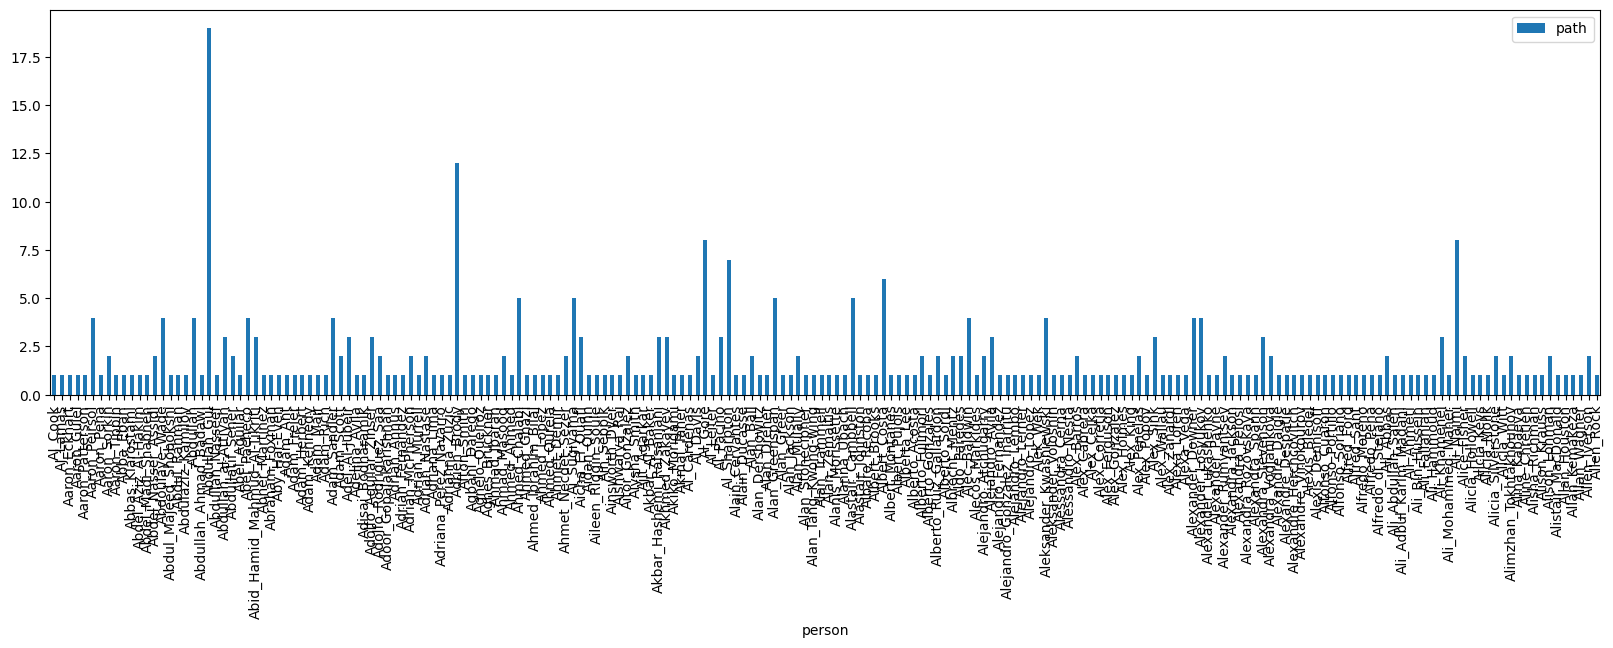

In [6]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

And take a random look at the photos of people in the dataset.

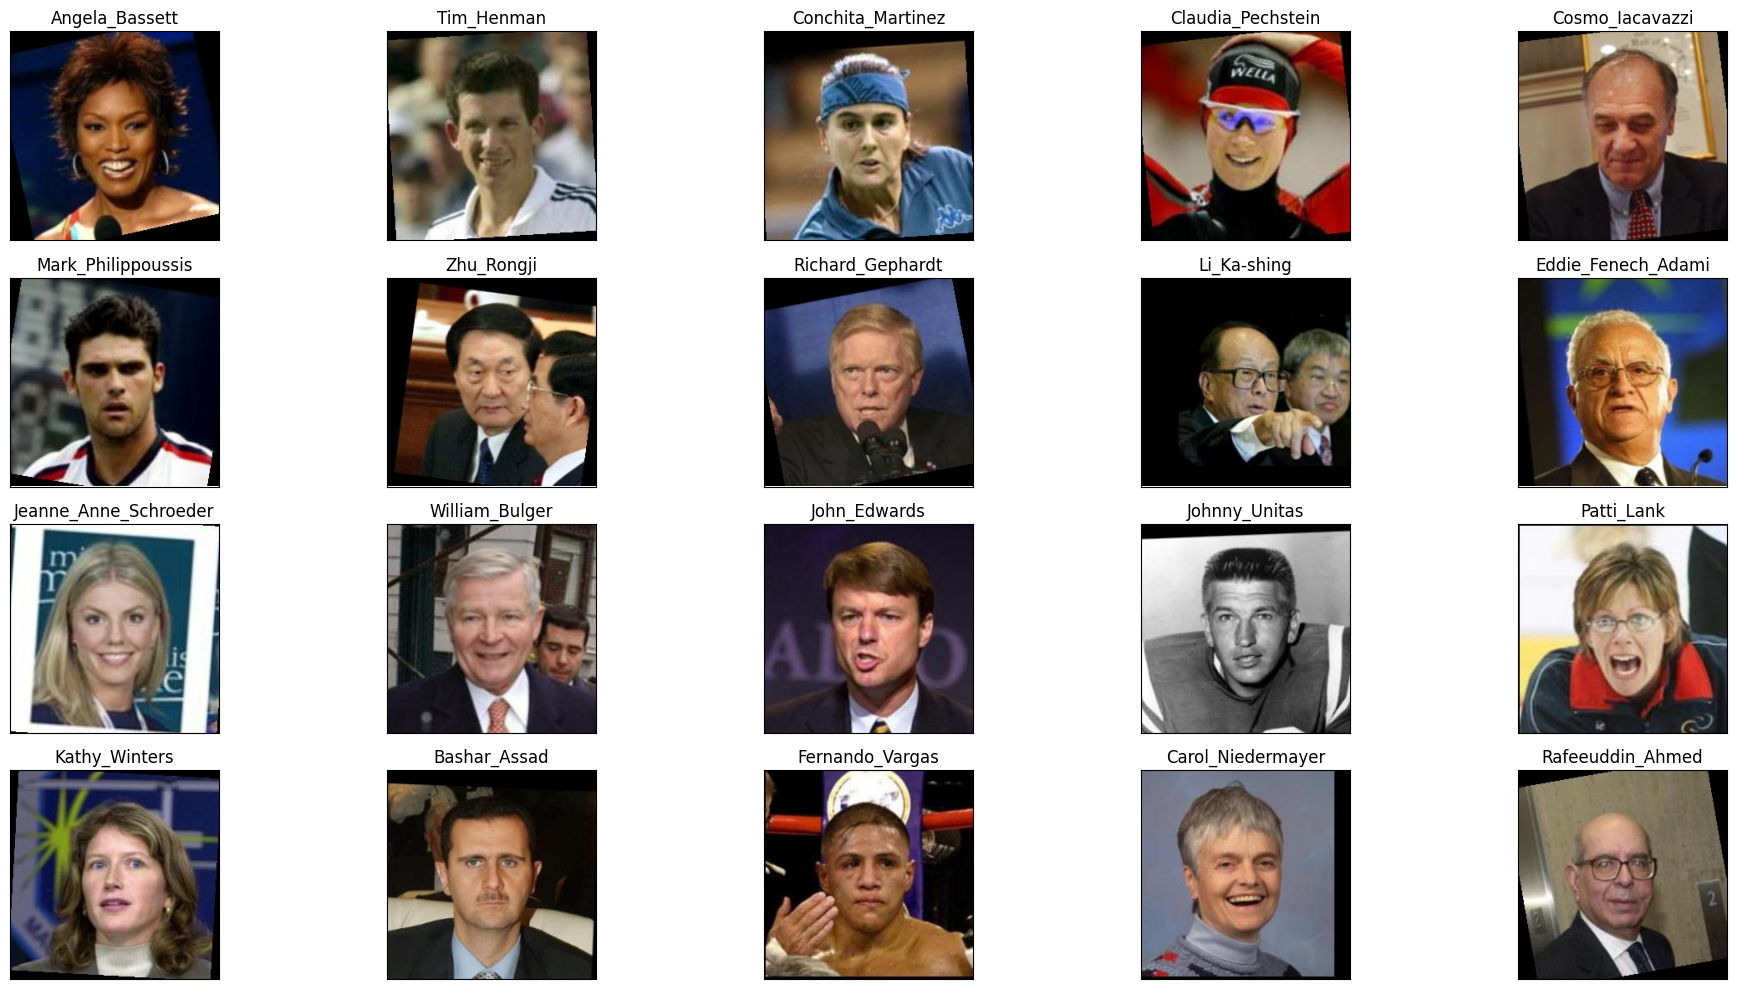

In [7]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Prepare the dataset

> - Reads the attribute data from the txt file at the specified path and stores it in a DataFrame object called df_attrs. The txt file is tab delimited, skipping the first line.
> - Empty list photo_ids for storing photo IDs, paths and person information. Use os.walk() to iterate through the files and folders under the specified path. For each file, if the filename ends in .jpg, extract its path, person information and photo number and add them to the photo_ids list.
> - Then convert the photo_ids list into a DataFrame object and merge it with df_attrs, based on common columns ("person" and "imagenum"). The result is stored in a DataFrame object called df.
> - Use the assertion statement to check that the length of the merged DataFrame object is the same as the length of the original attribute data to ensure that no data is missing.
> - Based on the paths of the photos in the merged DataFrame, the image data for each photo is read using the imageio.imread() function. Each image is then subjected to a series of processes, including cropping, resizing, etc., and the processed image data is stored in a NumPy array called all_photos.
> - Remove the photo path, person information and photo number from the merged DataFrame and store the result in a DataFrame object called all_attrs.

In [8]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [9]:
data, attrs = fetch_dataset()

Get the height and width of the image from data and define the number of channels.

In [10]:
#45,45
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

Normalize the data and divide the training and test sets.

In [11]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [12]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

## Building simple autoencoder

In [13]:
dim_z=100

In [14]:
X_train.shape

torch.Size([10514, 45, 45, 3])

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z),
            nn.BatchNorm1d(dim_z),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            #nn.Linear(500,1000),
            #nn.ReLU(),
            nn.Linear(1000,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,45*45*3)
        )
      
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        encoded = self.encode(x) 
        decoded = self.decode(encoded)     

        
        return encoded, decoded

This model will not be used in the following codes, but you can use it to instead of Autoencoder() to see the difference.

In [16]:
class Autoencoder_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5, stride=2)
        )
        
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        x = x.permute(0,3,1,2)
        encoded = self.encoder(x)  
        decoded = self.decode(encoded)     

        
        return encoded, decoded

In [17]:
model_auto = Autoencoder().to(DEVICE)

## Train autoencoder

> - get_batch: It uses the Generator method to generate batches of a specified size by iterating over them. The amount of data generated is batch_size each time, until the entire data set is traversed.
> - plot_gallery: This function is used to visualise an image.
> - fit_epoch: This function is used to perform the training process of the model. The function traverses the training data set, feeds the data into the model for forward propagation, calculates losses, back propagation and parameter updates. Finally the training loss is returned.
> - eval_epoch: This function is used to perform the validation process of the model. The function traverses the validation data set, feeds the data into the model for forward propagation and calculates the loss. Finally the validation loss is returned.


In [18]:
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        
def fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()
        
        encoder, decoder = model(inputs)
        
        #print('decoder shape: ', decoder.shape)
        
        if not is_cnn:
            outputs = decoder.view(-1, 45*45*3)
        else:
            outputs = decoder.permute(0,2,3,1)
        
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch(model, x_val, criterion, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val):
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)
            
            if not is_cnn:
                outputs = decoder.view(-1, 45*45*3)
            else:
                outputs = decoder.permute(0,2,3,1)
                
            loss = criterion(outputs,inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        
        if not is_cnn:            
            pic_input = pic.view(-1, 45*45*3)
        else:
            pic_input = torch.FloatTensor(pic.unsqueeze(0))
            
        pic_input = pic_input.to(DEVICE)        
        encoder, decoder = model(pic_input)
        
        if not is_cnn:
            pic_output = decoder.view(-1, 45*45*3).squeeze()
        else:
            pic_output = decoder.permute(0,2,3,1)
            
        pic_output = pic_output.to("cpu")        
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

In [19]:
def train(train_x, val_x, model, epochs=10, batch_size=32, is_cnn=False):     
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch(model,train_x,criterion,optimizer,batch_size,is_cnn)
            val_loss = eval_epoch(model,val_x,criterion, is_cnn)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:13<11:14, 13.76s/it]

loss:  0.029311008312039123

Epoch 001 train_loss: 0.0293 val_loss: 0.0163


epoch:   4%|▍         | 2/50 [00:16<05:47,  7.23s/it]

loss:  0.012578030433438454

Epoch 002 train_loss: 0.0126 val_loss: 0.0120


epoch:   6%|▌         | 3/50 [00:18<03:59,  5.09s/it]

loss:  0.010950946185113542

Epoch 003 train_loss: 0.0110 val_loss: 0.0108


epoch:   8%|▊         | 4/50 [00:21<03:07,  4.07s/it]

loss:  0.010177115111478738

Epoch 004 train_loss: 0.0102 val_loss: 0.0100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  10%|█         | 5/50 [00:23<02:36,  3.47s/it]

loss:  0.00939238341803336

Epoch 005 train_loss: 0.0094 val_loss: 0.0095


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  12%|█▏        | 6/50 [00:26<02:15,  3.09s/it]

loss:  0.008619437754736703

Epoch 006 train_loss: 0.0086 val_loss: 0.0085


epoch:  14%|█▍        | 7/50 [00:28<02:02,  2.85s/it]

loss:  0.008131832248445006

Epoch 007 train_loss: 0.0081 val_loss: 0.0081


epoch:  16%|█▌        | 8/50 [00:30<01:52,  2.69s/it]

loss:  0.007874895328688082

Epoch 008 train_loss: 0.0079 val_loss: 0.0079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  18%|█▊        | 9/50 [00:33<01:48,  2.66s/it]

loss:  0.007574663408131076

Epoch 009 train_loss: 0.0076 val_loss: 0.0078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  20%|██        | 10/50 [00:36<01:45,  2.63s/it]

loss:  0.007333762853393791

Epoch 010 train_loss: 0.0073 val_loss: 0.0074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  22%|██▏       | 11/50 [00:38<01:41,  2.61s/it]

loss:  0.007208034872019474

Epoch 011 train_loss: 0.0072 val_loss: 0.0072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  24%|██▍       | 12/50 [00:40<01:36,  2.53s/it]

loss:  0.007009298573603291

Epoch 012 train_loss: 0.0070 val_loss: 0.0072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  26%|██▌       | 13/50 [00:43<01:32,  2.50s/it]

loss:  0.006745042735280244

Epoch 013 train_loss: 0.0067 val_loss: 0.0071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  28%|██▊       | 14/50 [00:46<01:31,  2.53s/it]

loss:  0.006591338837731524

Epoch 014 train_loss: 0.0066 val_loss: 0.0069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  30%|███       | 15/50 [00:48<01:30,  2.60s/it]

loss:  0.006509212033129734

Epoch 015 train_loss: 0.0065 val_loss: 0.0067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  32%|███▏      | 16/50 [00:51<01:31,  2.70s/it]

loss:  0.0063268919593187055

Epoch 016 train_loss: 0.0063 val_loss: 0.0064


epoch:  34%|███▍      | 17/50 [00:54<01:30,  2.75s/it]

loss:  0.006158935812202548

Epoch 017 train_loss: 0.0062 val_loss: 0.0064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  36%|███▌      | 18/50 [00:57<01:26,  2.71s/it]

loss:  0.006016638908295724

Epoch 018 train_loss: 0.0060 val_loss: 0.0064


epoch:  38%|███▊      | 19/50 [00:59<01:21,  2.63s/it]

loss:  0.005846677434028176

Epoch 019 train_loss: 0.0058 val_loss: 0.0064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  40%|████      | 20/50 [01:02<01:21,  2.73s/it]

loss:  0.005869783889640471

Epoch 020 train_loss: 0.0059 val_loss: 0.0062


/tmp/ipykernel_16694/1482019581.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  42%|████▏     | 21/50 [01:05<01:19,  2.73s/it]

loss:  0.0058130240671950325

Epoch 021 train_loss: 0.0058 val_loss: 0.0062


epoch:  44%|████▍     | 22/50 [01:08<01:17,  2.78s/it]

loss:  0.005797080482241629

Epoch 022 train_loss: 0.0058 val_loss: 0.0063


epoch:  46%|████▌     | 23/50 [01:11<01:16,  2.84s/it]

loss:  0.005639933442616499

Epoch 023 train_loss: 0.0056 val_loss: 0.0061


epoch:  48%|████▊     | 24/50 [01:13<01:12,  2.80s/it]

loss:  0.005532207569280675

Epoch 024 train_loss: 0.0055 val_loss: 0.0060


epoch:  50%|█████     | 25/50 [01:16<01:08,  2.72s/it]

loss:  0.005554990382503314

Epoch 025 train_loss: 0.0056 val_loss: 0.0068


epoch:  52%|█████▏    | 26/50 [01:18<01:03,  2.64s/it]

loss:  0.0055116045257561684

Epoch 026 train_loss: 0.0055 val_loss: 0.0065


epoch:  54%|█████▍    | 27/50 [01:21<00:59,  2.57s/it]

loss:  0.005393432073181026

Epoch 027 train_loss: 0.0054 val_loss: 0.0065


epoch:  56%|█████▌    | 28/50 [01:23<00:56,  2.56s/it]

loss:  0.005328248787847777

Epoch 028 train_loss: 0.0053 val_loss: 0.0065


epoch:  58%|█████▊    | 29/50 [01:26<00:53,  2.55s/it]

loss:  0.00534546156333246

Epoch 029 train_loss: 0.0053 val_loss: 0.0063


epoch:  60%|██████    | 30/50 [01:28<00:51,  2.57s/it]

loss:  0.005295459738056855

Epoch 030 train_loss: 0.0053 val_loss: 0.0063


epoch:  62%|██████▏   | 31/50 [01:31<00:49,  2.58s/it]

loss:  0.005141445376766948

Epoch 031 train_loss: 0.0051 val_loss: 0.0060


epoch:  64%|██████▍   | 32/50 [01:34<00:46,  2.60s/it]

loss:  0.005035237498949545

Epoch 032 train_loss: 0.0050 val_loss: 0.0061


epoch:  66%|██████▌   | 33/50 [01:37<00:45,  2.65s/it]

loss:  0.005007141007371608

Epoch 033 train_loss: 0.0050 val_loss: 0.0062


epoch:  68%|██████▊   | 34/50 [01:39<00:43,  2.73s/it]

loss:  0.004952462918307744

Epoch 034 train_loss: 0.0050 val_loss: 0.0061


epoch:  70%|███████   | 35/50 [01:42<00:41,  2.77s/it]

loss:  0.004968051460224533

Epoch 035 train_loss: 0.0050 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  72%|███████▏  | 36/50 [01:45<00:39,  2.83s/it]

loss:  0.005063394174392184

Epoch 036 train_loss: 0.0051 val_loss: 0.0066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  74%|███████▍  | 37/50 [01:48<00:37,  2.88s/it]

loss:  0.005020533879387635

Epoch 037 train_loss: 0.0050 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  76%|███████▌  | 38/50 [01:51<00:35,  2.96s/it]

loss:  0.004952529138806248

Epoch 038 train_loss: 0.0050 val_loss: 0.0064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  78%|███████▊  | 39/50 [01:54<00:32,  2.96s/it]

loss:  0.004907616999284473

Epoch 039 train_loss: 0.0049 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  80%|████████  | 40/50 [01:57<00:29,  2.97s/it]

loss:  0.004799902857920278

Epoch 040 train_loss: 0.0048 val_loss: 0.0063


epoch:  82%|████████▏ | 41/50 [02:00<00:25,  2.87s/it]

loss:  0.004741736171878371

Epoch 041 train_loss: 0.0047 val_loss: 0.0063


epoch:  84%|████████▍ | 42/50 [02:03<00:22,  2.77s/it]

loss:  0.004748735925294664

Epoch 042 train_loss: 0.0047 val_loss: 0.0063


epoch:  86%|████████▌ | 43/50 [02:06<00:20,  2.91s/it]

loss:  0.004796392727318697

Epoch 043 train_loss: 0.0048 val_loss: 0.0066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  88%|████████▊ | 44/50 [02:09<00:17,  2.89s/it]

loss:  0.004841103816273133

Epoch 044 train_loss: 0.0048 val_loss: 0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  90%|█████████ | 45/50 [02:11<00:14,  2.88s/it]

loss:  0.004741450785463493

Epoch 045 train_loss: 0.0047 val_loss: 0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  92%|█████████▏| 46/50 [02:14<00:11,  2.88s/it]

loss:  0.004715808126023112

Epoch 046 train_loss: 0.0047 val_loss: 0.0066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  94%|█████████▍| 47/50 [02:17<00:08,  2.78s/it]

loss:  0.004732677623217145

Epoch 047 train_loss: 0.0047 val_loss: 0.0068


epoch:  96%|█████████▌| 48/50 [02:20<00:05,  2.73s/it]

loss:  0.004688484010045516

Epoch 048 train_loss: 0.0047 val_loss: 0.0067


epoch:  98%|█████████▊| 49/50 [02:22<00:02,  2.71s/it]

loss:  0.004662725777362256

Epoch 049 train_loss: 0.0047 val_loss: 0.0069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch: 100%|██████████| 50/50 [02:25<00:00,  2.91s/it]


loss:  0.004687491493182324

Epoch 050 train_loss: 0.0047 val_loss: 0.0064


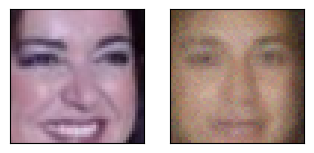

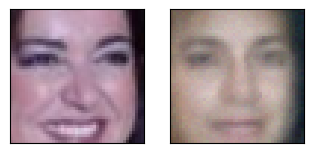

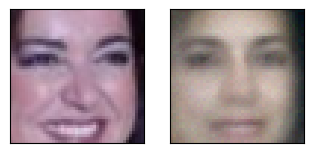

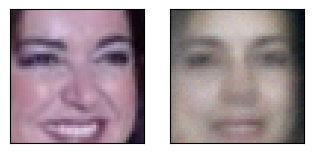

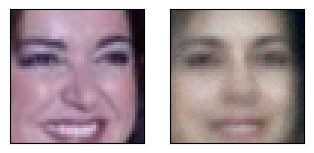

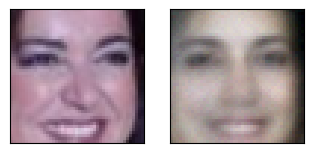

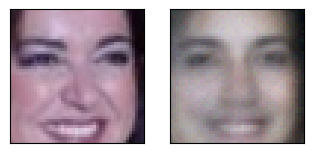

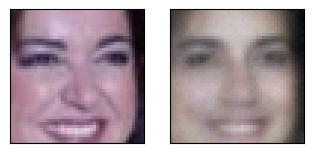

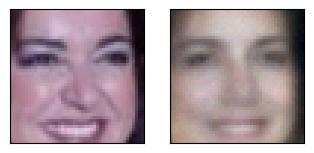

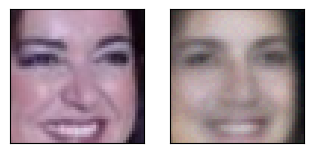

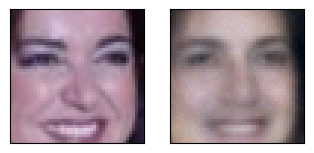

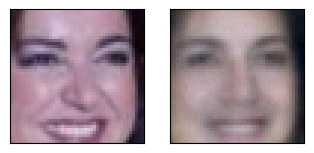

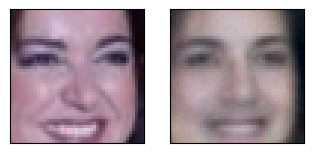

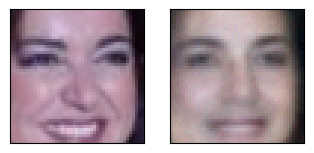

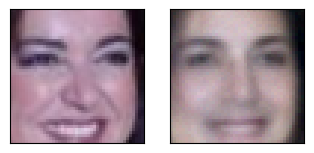

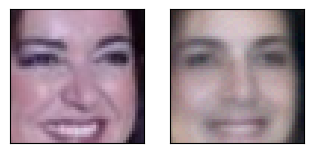

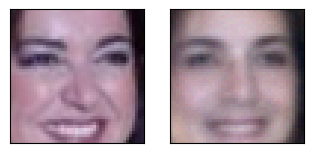

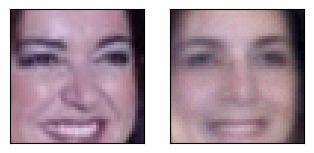

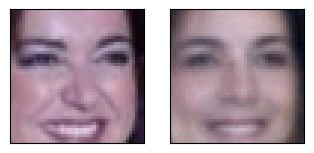

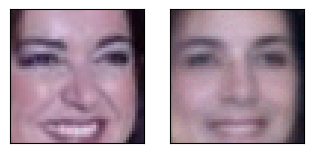

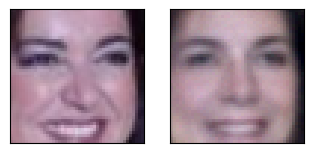

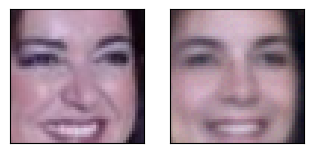

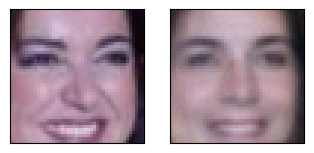

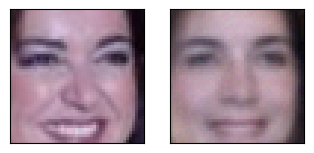

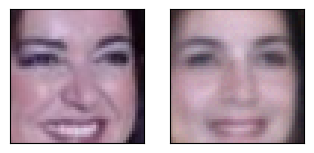

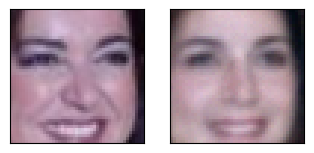

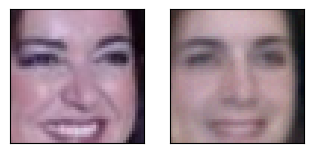

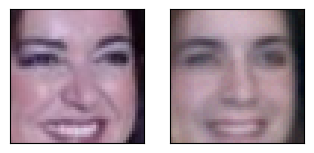

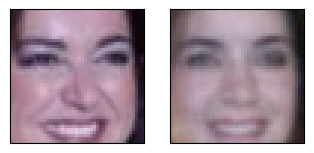

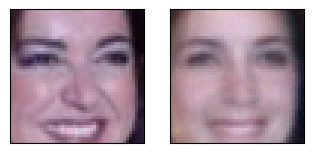

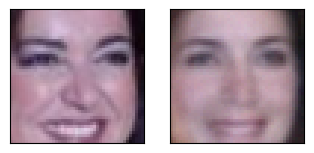

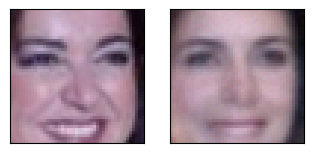

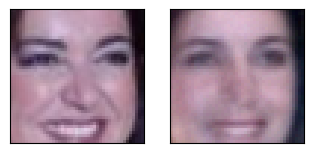

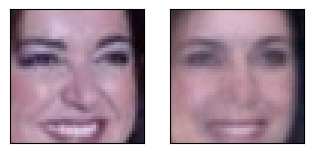

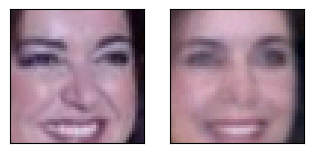

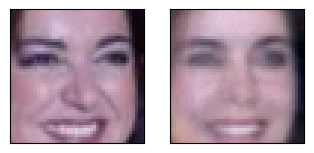

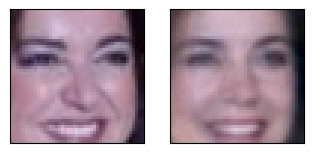

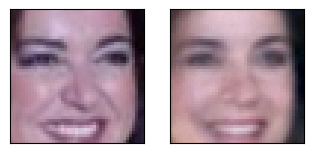

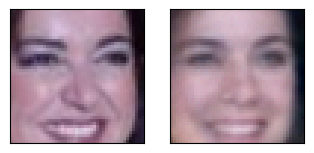

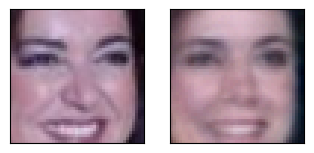

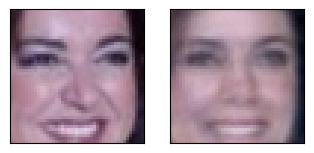

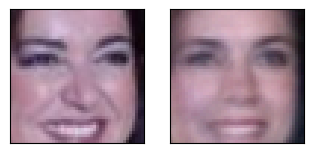

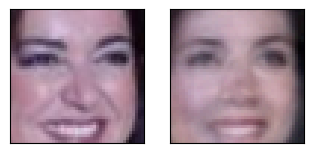

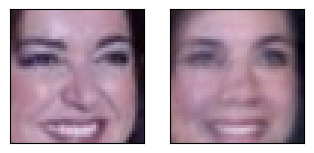

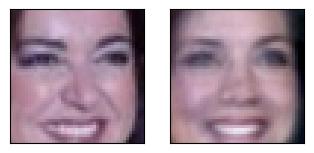

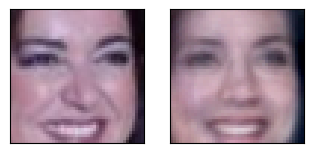

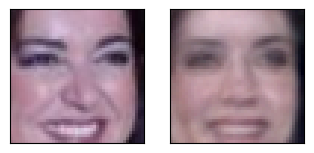

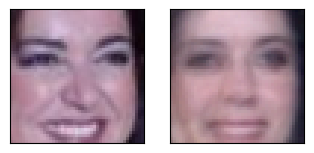

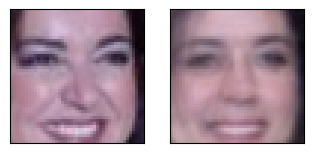

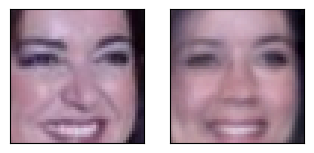

In [20]:
history = train(X_train, X_val, model_auto, epochs=50, batch_size=64)

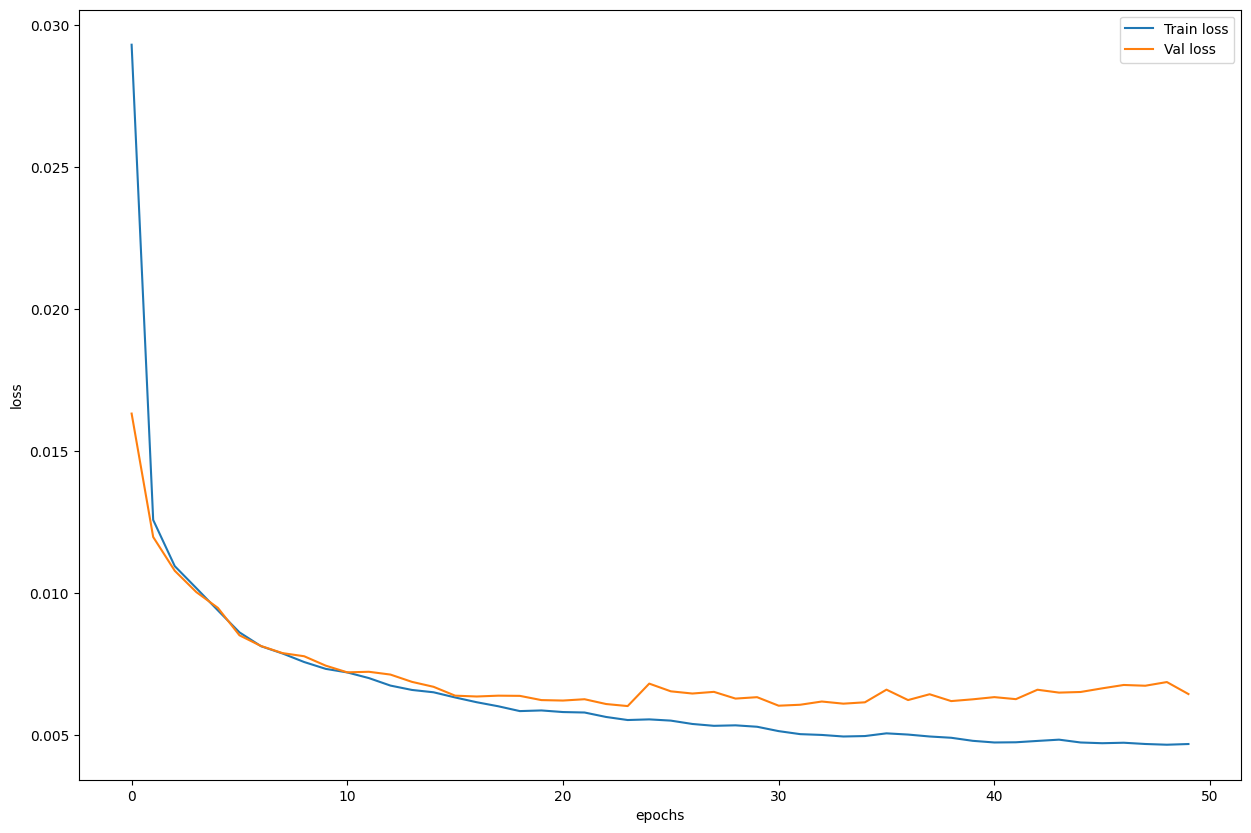

In [21]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

## Sampling

Let's generate some samples from random vectors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

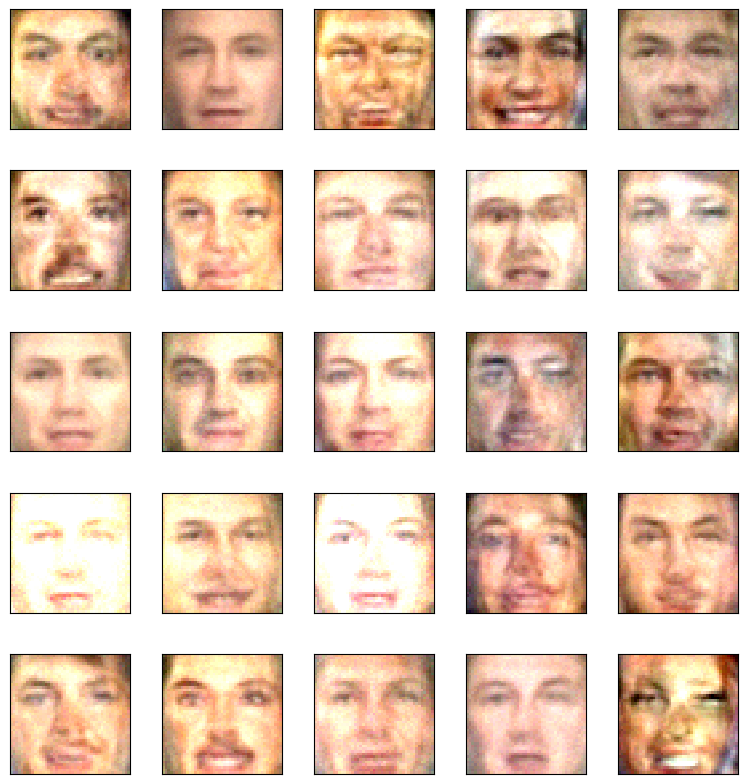

In [22]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(DEVICE)
    model_auto.eval()
    output = model_auto.decode(inputs)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Adding smile and glasses

Let's find some attributes like smiles or glasses on the photo and try to add it to the photos which don't have it. We will use the second dataset for it. It contains a bunch of such attributes. 

In [23]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [24]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [25]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

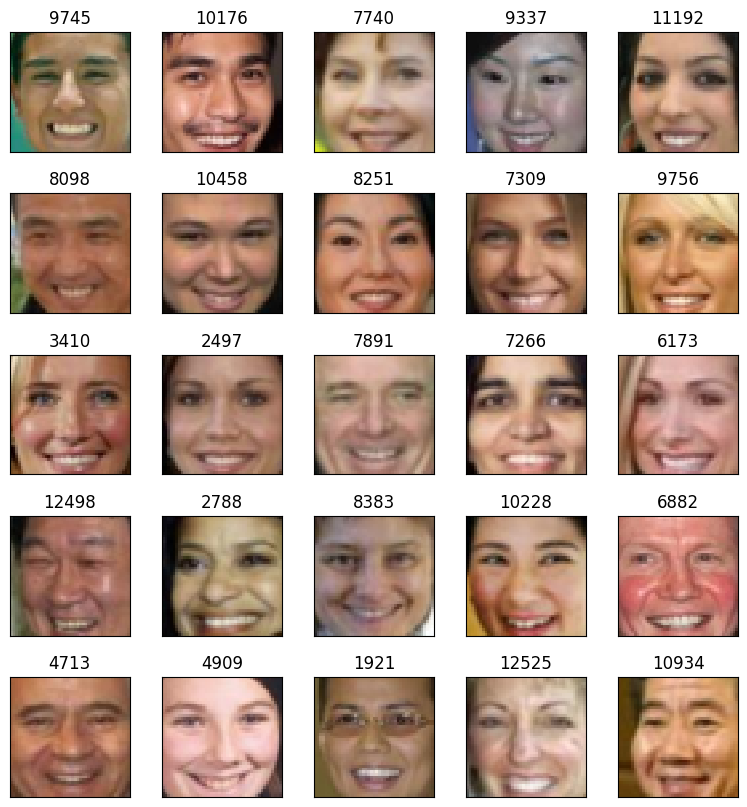

In [26]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=smile_ids)

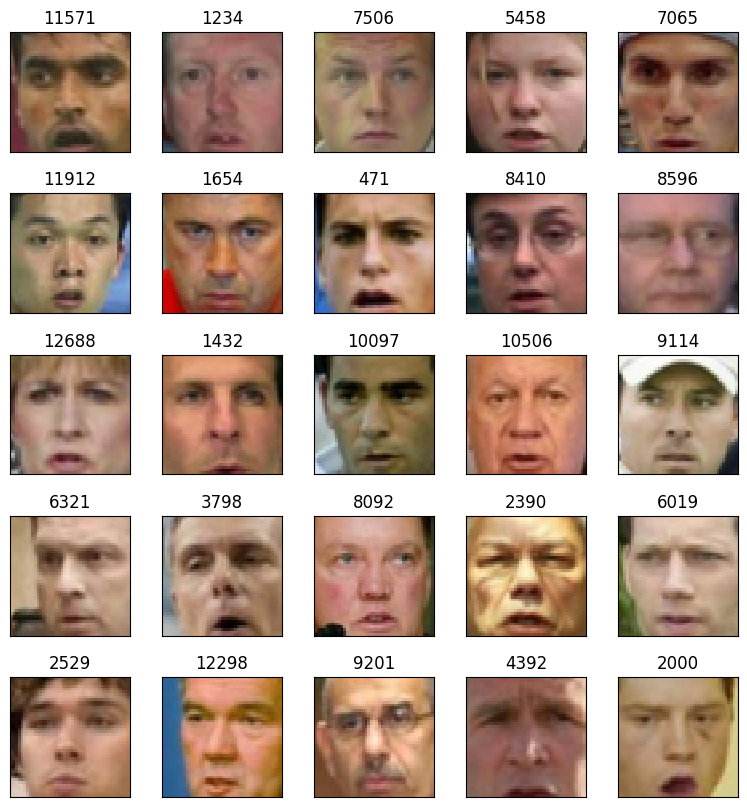

In [27]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=no_smile_ids)

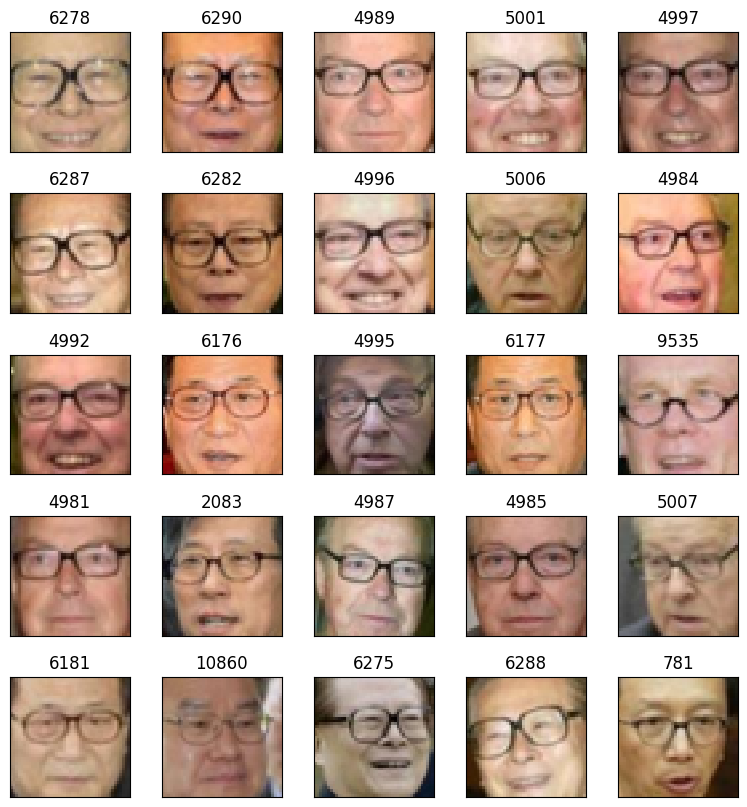

In [28]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=eyeglasses_ids)

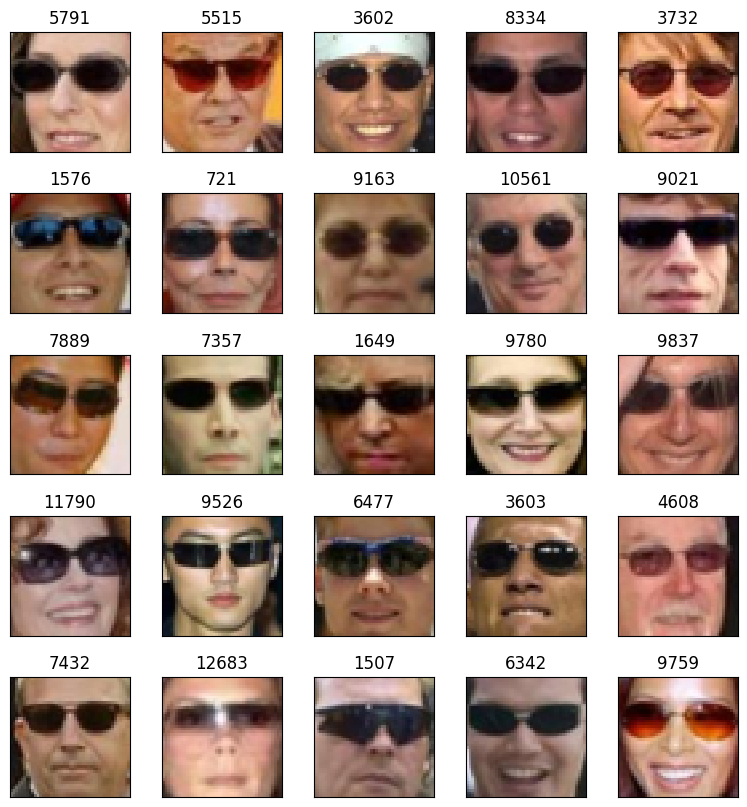

In [29]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=sunglasses_ids)

Calculating latent space vector for the selected images.

In [30]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model_auto.eval()
        output = model_auto.encode(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model_auto.eval()
        output = model_auto.decode(inputs)        
        return output

In [31]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
sunglasses_vec = sunglasses_latent - smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

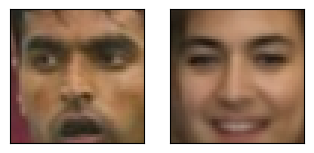

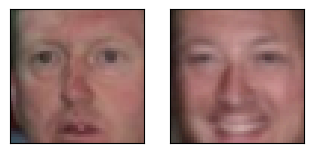

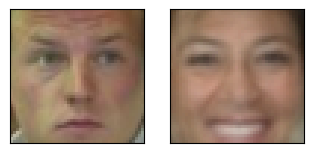

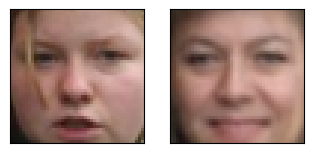

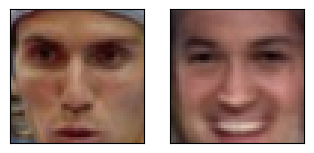

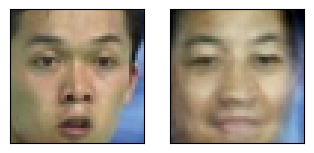

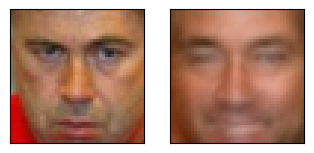

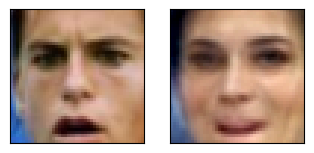

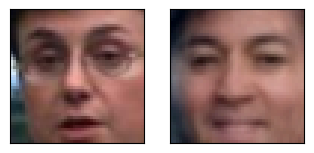

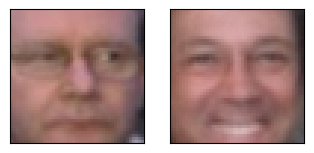

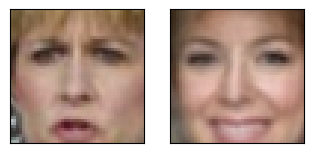

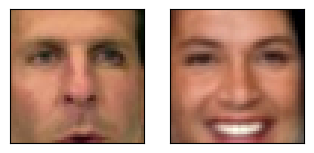

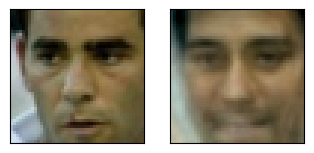

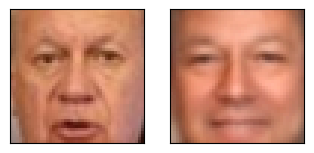

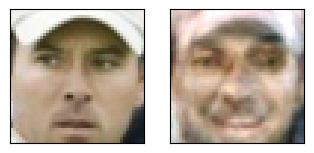

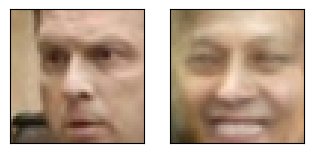

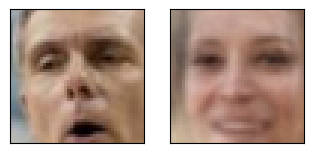

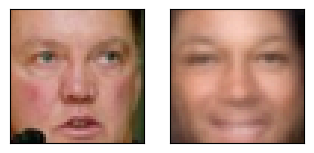

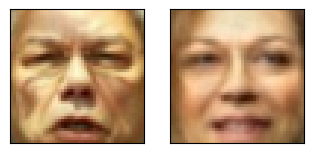

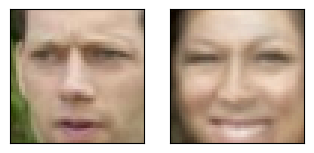

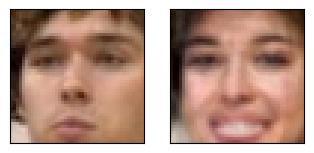

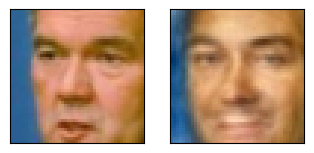

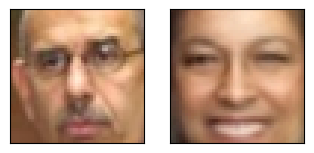

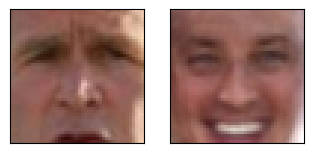

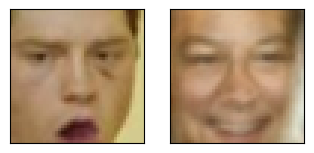

In [32]:
make_me_smile(no_smile_ids)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

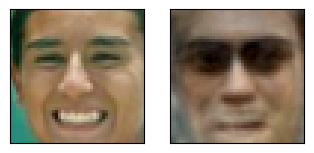

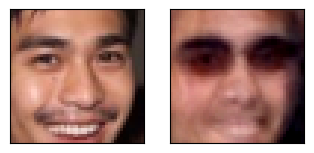

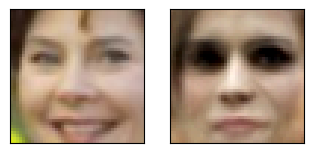

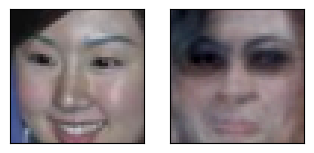

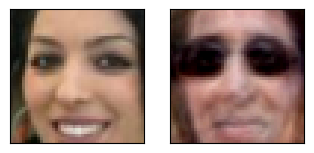

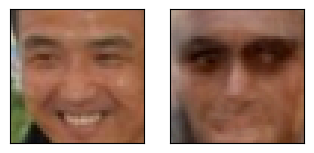

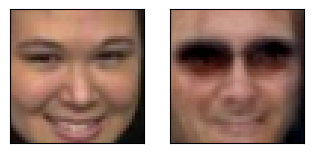

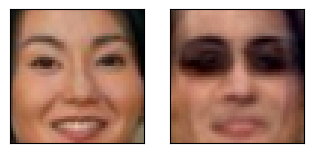

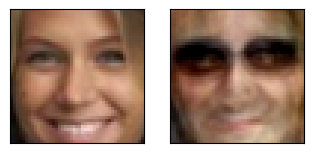

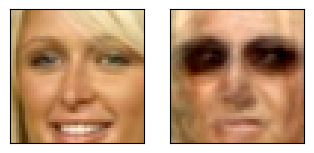

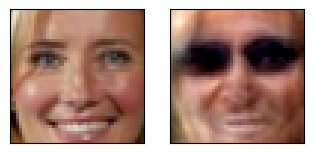

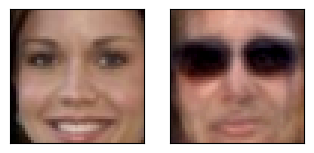

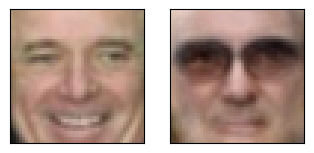

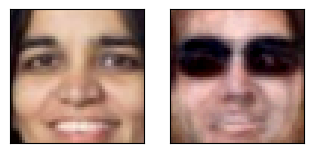

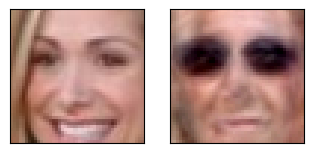

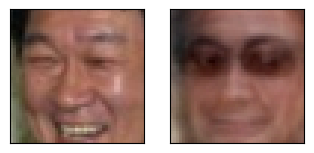

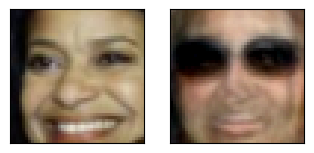

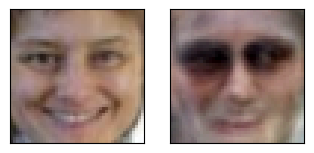

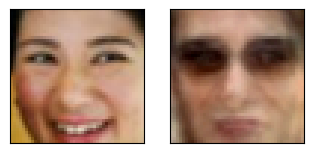

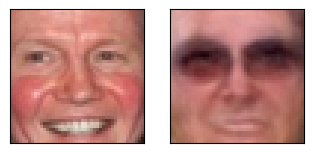

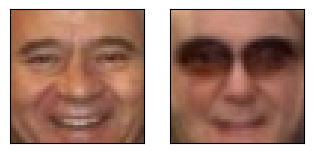

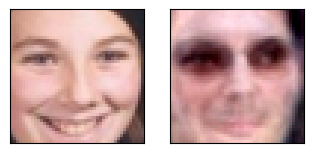

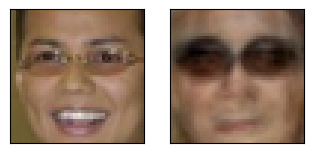

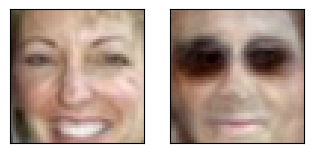

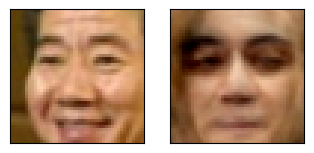

In [33]:
give_me_sunglasses(smile_ids)

While the concept is pretty straightforward the simple autoencoder have some disadvantages. Let's explore them and try to do better.

## Variational autoencoder

So far we have trained our encoder to reconstruct the very same image that we've transfered to latent space. That means that when we're trying to **generate** new image from the point decoder never met we're getting _the best image it can produce_, but the quelity is not good enough. 

> **In other words the encoded vectors may not be continuous in the latent space.**

In other hand Variational Autoencoders makes not only one encoded vector but **two**:
- vector of means, μ;
- vector of standard deviations, σ.

![https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png](https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png)




So we're going to try to use VAE to create better new data. The difference in thinking between VAE and AE is that VAE does not map images as "numerical codes", but as "distributions". 

It will be easier to understand with another simpler example, if we map the 'new moon' image to a normal distribution with µ=1, then it is equivalent to adding noise around 1, where not only does 1 represent the 'new moon', but the values around 1 also represent The "new moon" is not only represented by 1, but also by the values around 1, except that 1 is most like the "new moon". Mapping the "full moon" to a normal distribution with µ=10, all values around 10 also represent the "full moon". Then with code=5, it has the characteristics of both a 'new moon' and a 'full moon', so the probability of decoding is a 'half moon'. This is the idea behind VAE.

![](https://img2020.cnblogs.com/blog/2226924/202104/2226924-20210421184519712-1309789927.jpg)

The overall structure of VAE is similar to that of AE, except that the Encoder of AE outputs the code directly, whereas the Encoder of VAE outputs a number of normally distributed means (μ1, μ2...μn) and standard deviations (σ1,σ2...σn), and then from each normal distribution N(μ1,σ21),N(μ2,σ22)...N(μn,σ2n) Sampling gives the code (Z1,Z2...Zn) and the code is fed to the Decoder for decoding.

In [34]:
dim_z = 256

In [35]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [36]:
model_vae = VAE().to(DEVICE)

In [37]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(DEVICE)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   2%|▏         | 1/50 [00:02<01:40,  2.04s/it]

loss:  507433.3936269498

Epoch 001 train_loss: 507433.3936 val_loss: 494061.1292


epoch:   4%|▍         | 2/50 [00:03<01:10,  1.48s/it]

loss:  495593.2077081748

Epoch 002 train_loss: 495593.2077 val_loss: 488601.0043


epoch:   6%|▌         | 3/50 [00:04<01:00,  1.28s/it]

loss:  492821.2207116702

Epoch 003 train_loss: 492821.2207 val_loss: 490420.2231


epoch:   8%|▊         | 4/50 [00:05<00:55,  1.22s/it]

loss:  491549.4530804166

Epoch 004 train_loss: 491549.4531 val_loss: 486197.5026


epoch:  10%|█         | 5/50 [00:06<01:01,  1.36s/it]

loss:  489239.50681531767

Epoch 005 train_loss: 489239.5068 val_loss: 484707.4004


epoch:  12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

loss:  488165.90181543655

Epoch 006 train_loss: 488165.9018 val_loss: 482829.1165


epoch:  14%|█▍        | 7/50 [00:09<01:01,  1.42s/it]

loss:  488419.97880653176

Epoch 007 train_loss: 488419.9788 val_loss: 482676.0363


epoch:  16%|█▌        | 8/50 [00:11<00:59,  1.43s/it]

loss:  486632.7757067957

Epoch 008 train_loss: 486632.7757 val_loss: 483695.3749


epoch:  18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

loss:  485897.79108955915

Epoch 009 train_loss: 485897.7911 val_loss: 480865.4694


epoch:  20%|██        | 10/50 [00:13<00:51,  1.29s/it]

loss:  485279.88508625404

Epoch 010 train_loss: 485279.8851 val_loss: 481151.0186


epoch:  22%|██▏       | 11/50 [00:14<00:48,  1.25s/it]

loss:  485588.88617557543

Epoch 011 train_loss: 485588.8862 val_loss: 479622.5289


epoch:  24%|██▍       | 12/50 [00:15<00:45,  1.20s/it]

loss:  484476.0013746552

Epoch 012 train_loss: 484476.0014 val_loss: 478832.5101


epoch:  26%|██▌       | 13/50 [00:16<00:43,  1.17s/it]

loss:  484177.3917276964

Epoch 013 train_loss: 484177.3917 val_loss: 480934.3097


epoch:  28%|██▊       | 14/50 [00:18<00:41,  1.15s/it]

loss:  483199.53760165017

Epoch 014 train_loss: 483199.5376 val_loss: 477918.8730


epoch:  30%|███       | 15/50 [00:19<00:40,  1.16s/it]

loss:  482650.594259737

Epoch 015 train_loss: 482650.5943 val_loss: 478265.8287


epoch:  32%|███▏      | 16/50 [00:20<00:39,  1.15s/it]

loss:  483119.7869685657

Epoch 016 train_loss: 483119.7870 val_loss: 477469.7684


epoch:  34%|███▍      | 17/50 [00:21<00:38,  1.16s/it]

loss:  481994.401246255

Epoch 017 train_loss: 481994.4012 val_loss: 477539.9339


epoch:  36%|███▌      | 18/50 [00:22<00:36,  1.15s/it]

loss:  481818.0318578205

Epoch 018 train_loss: 481818.0319 val_loss: 477170.0321


epoch:  38%|███▊      | 19/50 [00:23<00:35,  1.16s/it]

loss:  482700.5061421081

Epoch 019 train_loss: 482700.5061 val_loss: 480357.3390


epoch:  40%|████      | 20/50 [00:25<00:34,  1.17s/it]

loss:  481833.7675807257

Epoch 020 train_loss: 481833.7676 val_loss: 476981.6270


/tmp/ipykernel_16694/1482019581.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
epoch:  42%|████▏     | 21/50 [00:26<00:34,  1.19s/it]

loss:  481214.0627273754

Epoch 021 train_loss: 481214.0627 val_loss: 476699.8500


epoch:  44%|████▍     | 22/50 [00:27<00:35,  1.27s/it]

loss:  481294.1564877782

Epoch 022 train_loss: 481294.1565 val_loss: 475989.0012


epoch:  46%|████▌     | 23/50 [00:29<00:35,  1.33s/it]

loss:  480845.6159376783

Epoch 023 train_loss: 480845.6159 val_loss: 476228.4255


epoch:  48%|████▊     | 24/50 [00:30<00:35,  1.35s/it]

loss:  480676.60560770164

Epoch 024 train_loss: 480676.6056 val_loss: 476788.3361


epoch:  50%|█████     | 25/50 [00:31<00:32,  1.29s/it]

loss:  480719.9602375404

Epoch 025 train_loss: 480719.9602 val_loss: 476451.1102


epoch:  52%|█████▏    | 26/50 [00:32<00:30,  1.25s/it]

loss:  480683.7350987374

Epoch 026 train_loss: 480683.7351 val_loss: 475686.7433


epoch:  54%|█████▍    | 27/50 [00:33<00:27,  1.20s/it]

loss:  480317.8506425956

Epoch 027 train_loss: 480317.8506 val_loss: 476877.3817


epoch:  56%|█████▌    | 28/50 [00:35<00:25,  1.16s/it]

loss:  480473.9431739823

Epoch 028 train_loss: 480473.9432 val_loss: 476471.1661


epoch:  58%|█████▊    | 29/50 [00:36<00:23,  1.13s/it]

loss:  480389.8370431686

Epoch 029 train_loss: 480389.8370 val_loss: 476669.2394


epoch:  60%|██████    | 30/50 [00:37<00:23,  1.16s/it]

loss:  480091.1417380992

Epoch 030 train_loss: 480091.1417 val_loss: 475568.1913


epoch:  62%|██████▏   | 31/50 [00:38<00:22,  1.20s/it]

loss:  479729.808581118

Epoch 031 train_loss: 479729.8086 val_loss: 477032.9246


epoch:  64%|██████▍   | 32/50 [00:39<00:21,  1.18s/it]

loss:  480153.0204623003

Epoch 032 train_loss: 480153.0205 val_loss: 475174.1957


epoch:  66%|██████▌   | 33/50 [00:40<00:19,  1.16s/it]

loss:  479814.6451249524

Epoch 033 train_loss: 479814.6451 val_loss: 474881.9613


epoch:  68%|██████▊   | 34/50 [00:41<00:18,  1.14s/it]

loss:  479343.1330889172

Epoch 034 train_loss: 479343.1331 val_loss: 475227.9744


epoch:  70%|███████   | 35/50 [00:43<00:17,  1.13s/it]

loss:  479848.77157391334

Epoch 035 train_loss: 479848.7716 val_loss: 478115.8558


epoch:  72%|███████▏  | 36/50 [00:44<00:15,  1.14s/it]

loss:  480075.2510016407

Epoch 036 train_loss: 480075.2510 val_loss: 474878.5953


epoch:  74%|███████▍  | 37/50 [00:45<00:15,  1.16s/it]

loss:  479105.0973345064

Epoch 037 train_loss: 479105.0973 val_loss: 474908.6188


epoch:  76%|███████▌  | 38/50 [00:47<00:15,  1.28s/it]

loss:  479136.7819900846

Epoch 038 train_loss: 479136.7820 val_loss: 475821.2043


epoch:  78%|███████▊  | 39/50 [00:48<00:14,  1.34s/it]

loss:  479186.359009416

Epoch 039 train_loss: 479186.3590 val_loss: 474325.6403


epoch:  80%|████████  | 40/50 [00:49<00:13,  1.37s/it]

loss:  478787.90612813865

Epoch 040 train_loss: 478787.9061 val_loss: 474321.9003


epoch:  82%|████████▏ | 41/50 [00:51<00:12,  1.41s/it]

loss:  480318.00581664924

Epoch 041 train_loss: 480318.0058 val_loss: 475372.8412


epoch:  84%|████████▍ | 42/50 [00:52<00:11,  1.42s/it]

loss:  478796.80592543277

Epoch 042 train_loss: 478796.8059 val_loss: 474168.2760


epoch:  86%|████████▌ | 43/50 [00:54<00:10,  1.43s/it]

loss:  478605.2524832961

Epoch 043 train_loss: 478605.2525 val_loss: 474105.5996


epoch:  88%|████████▊ | 44/50 [00:55<00:08,  1.40s/it]

loss:  478350.9308451826

Epoch 044 train_loss: 478350.9308 val_loss: 474164.1747


epoch:  90%|█████████ | 45/50 [00:56<00:06,  1.30s/it]

loss:  478350.0592795915

Epoch 045 train_loss: 478350.0593 val_loss: 473749.8256


epoch:  92%|█████████▏| 46/50 [00:57<00:04,  1.24s/it]

loss:  478300.22526363656

Epoch 046 train_loss: 478300.2253 val_loss: 473611.5912


epoch:  94%|█████████▍| 47/50 [00:58<00:03,  1.19s/it]

loss:  478235.23449983355

Epoch 047 train_loss: 478235.2345 val_loss: 474054.7031


epoch:  96%|█████████▌| 48/50 [00:59<00:02,  1.15s/it]

loss:  478161.11150014267

Epoch 048 train_loss: 478161.1115 val_loss: 474944.3206


epoch:  98%|█████████▊| 49/50 [01:01<00:01,  1.13s/it]

loss:  478231.08879381063

Epoch 049 train_loss: 478231.0888 val_loss: 473623.7098


epoch: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]

loss:  478205.65478915017

Epoch 050 train_loss: 478205.6548 val_loss: 473955.4132


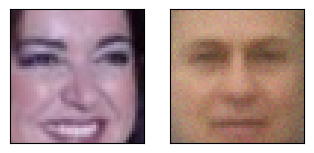

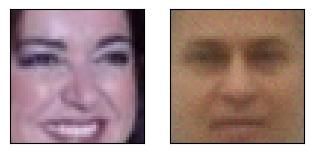

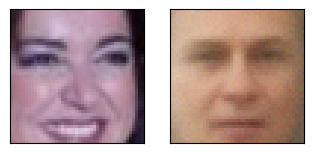

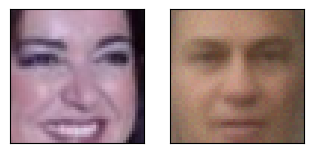

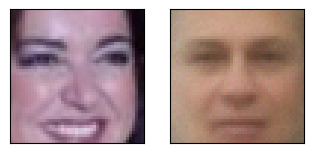

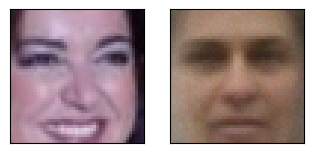

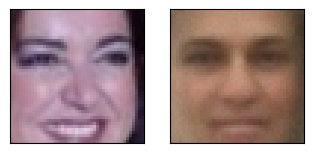

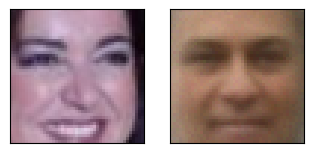

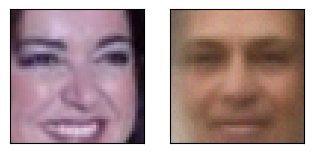

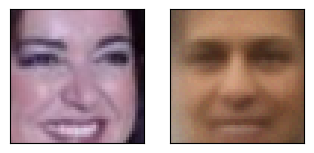

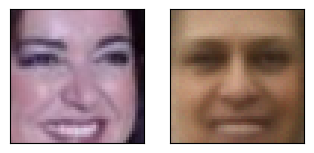

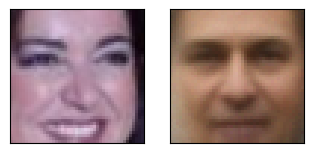

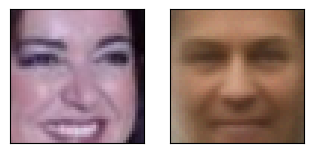

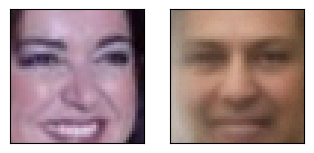

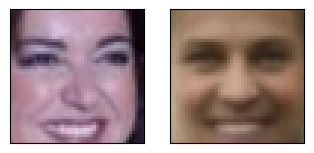

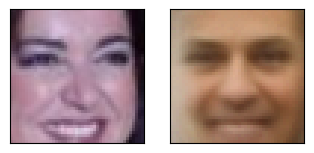

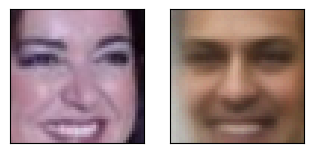

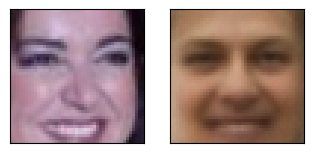

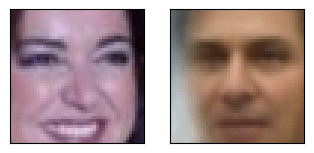

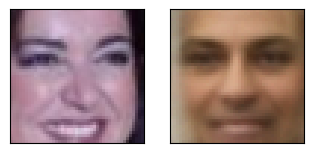

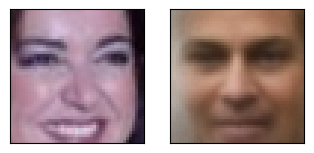

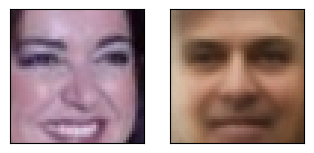

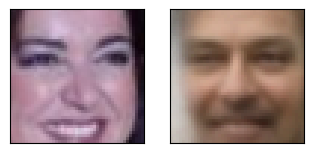

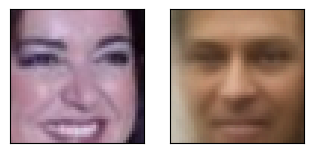

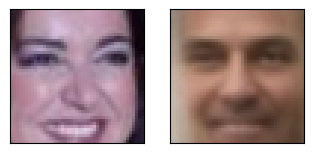

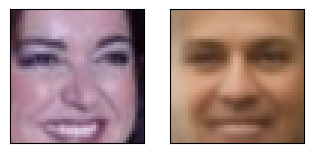

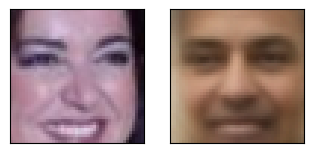

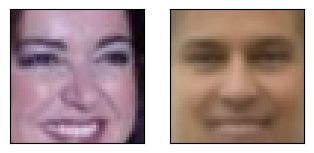

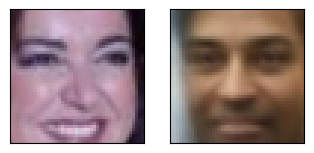

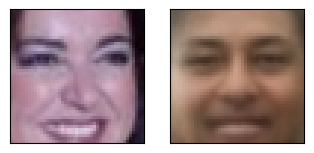

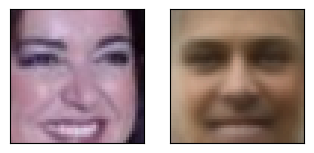

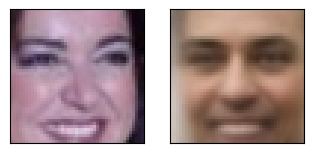

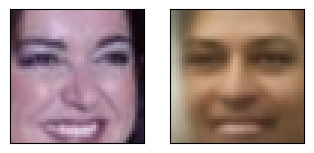

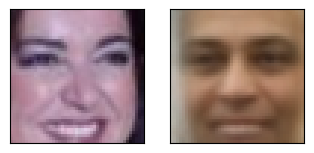

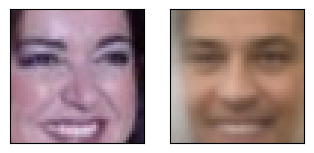

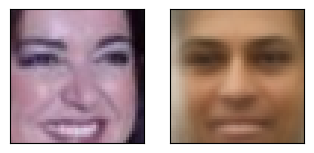

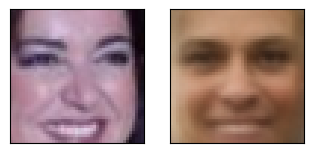

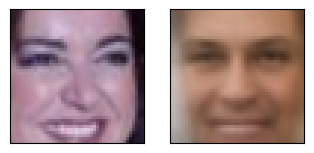

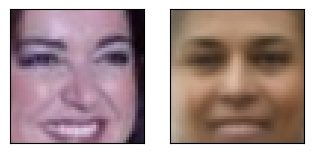

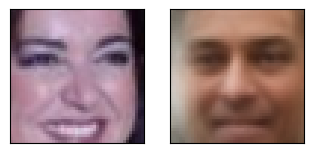

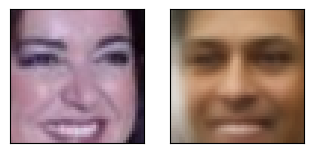

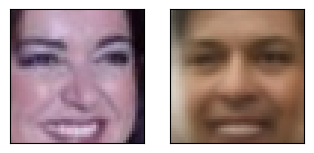

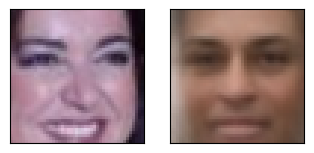

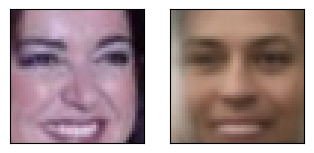

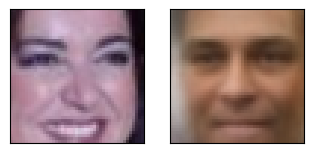

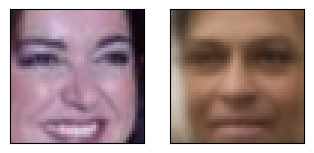

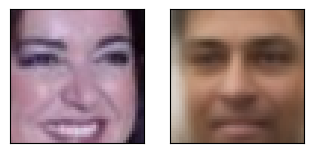

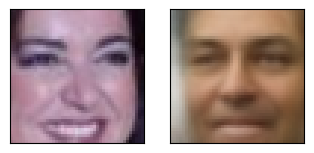

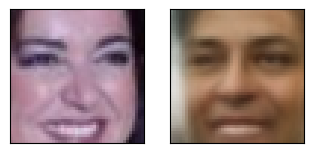

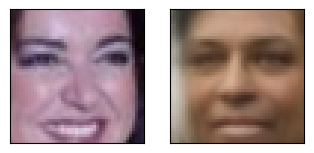

In [38]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=50, batch_size=128, lr=0.001)

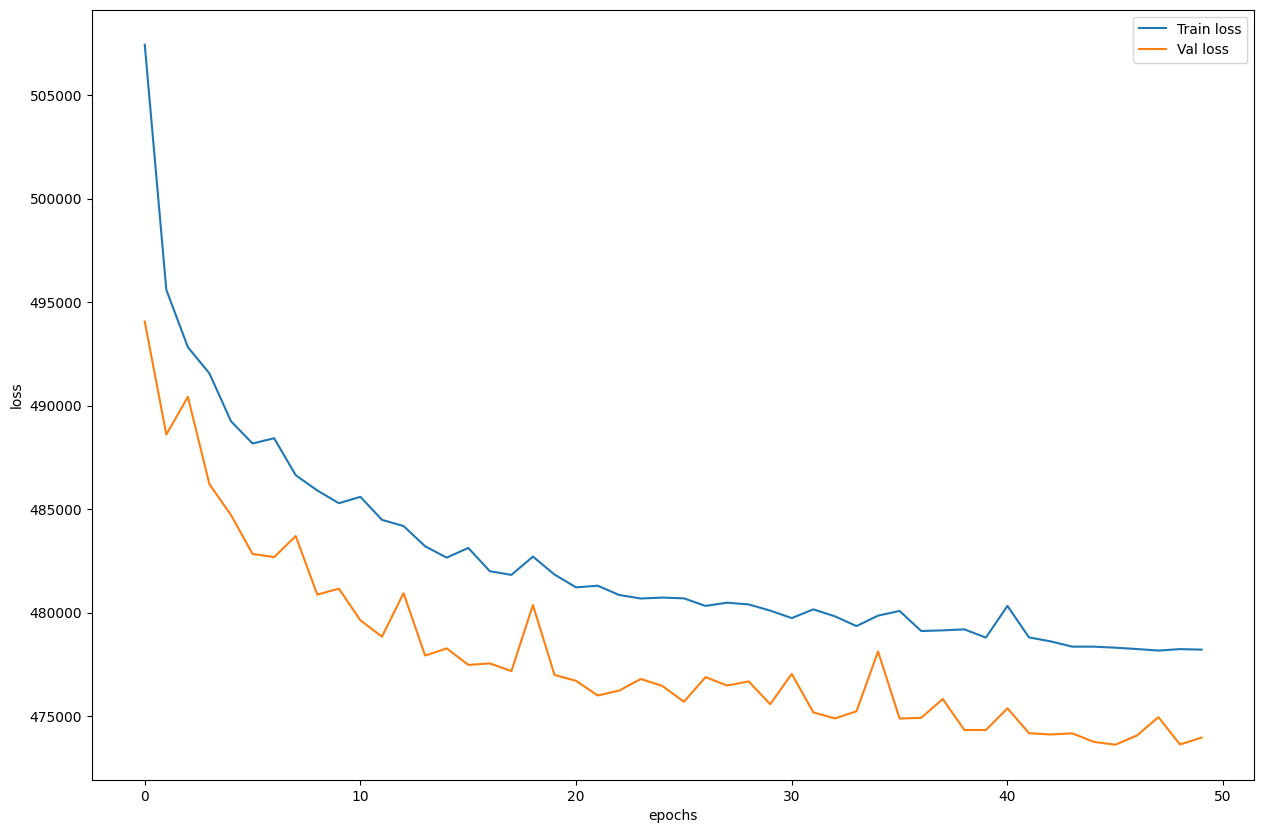

In [39]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

## Conclusion

Variational autoencoders are cool. Although models in this particular notebook are simple they let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces and high-resolution digital artwork.
These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma et al. and Rezende et al.

## Acknowledgments

Thanks to SERGEI AVERKIEV for creating the Kaggle open-source project [Variational Autoencoder and Faces Generation](https://www.kaggle.com/code/averkij/variational-autoencoder-and-faces-generation). It inspires the majority of the content in this chapter.